In [519]:
#Uses debiased sinkhorn method to compare random PAIRS of images
#to visualize and determine robustness to noise

import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import ot
import os
import warnings
import sys
import sinkhorn_barycenters as sink
from itertools import combinations

#set variables
n = 2 #choosing n pairs (noise, no noise) of random datasets
epsilon = 1e-1 #will optimize this later
max_iterations = 30000 #will optimize this later
width = 50
rng = np.random.RandomState(42)#42


In [520]:
#function to choose n random artificial datasets
def find_index(n):
    index = rng.choice(np.arange(200), size=(n), replace=False)
    index.sort()
    return index

#returing variables
index = find_index(n)


In [521]:
#load datasets, this function takes the random indexes and loads n pairs of artificial data with and without noise
def load_data(num_pairs, index):
    noise = []
    nonoise = []
    for i in range(len(index)):
        noise.append(abs(np.load("./artificial_data.npy")[index[i], :, :]))
        nonoise.append(np.load("./artificial_data_no_noise.npy")[index[i], :, :])
    return np.asarray(noise), np.asarray(nonoise)
        

#returning variables
noise, nonoise = load_data(n,index) 


In [522]:
#formatting function
def debiased_format(dataset, epsilon):
    P = torch.from_numpy(dataset)    
    grid = torch.arange(width).type(torch.float64)
    grid /= width
    M = (grid[:, None] - grid[None, :]) ** 2
    K = torch.exp(- M / epsilon)
    #K = torch.from_numpy(K)
    return P, K

#creating variables for debiased algo
P_nonoise, K_nonoise = debiased_format(nonoise, epsilon)
P_noise, K_noise = debiased_format(noise, epsilon)

print(P_nonoise.shape)
print(K_nonoise.shape)

torch.Size([2, 50, 50])
torch.Size([50, 50])


In [523]:
##Runs every combination of pairs for data sets within noise and no noise respectively

def run_sinkhorn(n, index, max_iterations, P_noise, K_noise, P_nonoise, K_nonoise):
    #row_num = int((n*(n-1))/2)
    q_nonoise = []
    q_noise = []
    index_list = []
    for i in range(len(index)):
        index_list.append(i)
    #list of all unique combinations of pairs of indices of datasets    
    combo_list = list(combinations(index_list,2)) 

    for i in range(len(combo_list)):
        first_set = combo_list[i][0]
        second_set = combo_list[i][1]
        #number for the image corresponding to the dataset
        image_nums = [index[first_set],index[second_set]] 
        #getting indices for all possible combinations of pairs
        ind = torch.tensor([first_set, second_set])
        #all possible combinations of pairs of images with no noise
        Pnonoise = torch.index_select(P_nonoise, 0, ind)
        qnonoise = sink.barycenter(Pnonoise, K_nonoise, reference="debiased", maxiter = max_iterations)
        q_nonoise.append(qnonoise)

        #all possible combinations of pairs of images with noise
        Pnoise = torch.index_select(P_noise, 0, ind)
        qnoise = sink.barycenter(Pnoise, K_noise, reference="debiased", maxiter = max_iterations)
        q_noise.append(qnoise)
        
    return combo_list, image_nums, q_nonoise, q_noise

#combo_list, image_nums, q_nonoise, q_noise = run_sinkhorn(n, index, max_iterations, P_noise, K_noise, P_nonoise, K_nonoise)        




In [524]:
#plotting just the barycenters
##NEED to add a way to the plots to see which images aren't working (or get nans)
#also should see if I can optimize the regularization

def plot_compare(q_noise, q_nonoise):
    for i in range(0,len(q_noise)):
        print(i)
        plt.figure(i+1, figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(q_nonoise[i])
        plt.title("No Noise")

        plt.subplot(1,2,2)
        plt.imshow(q_noise[i])
        plt.title("Noise")
        plt.axis("off")

#plot_compare(q_noise, q_nonoise)   

In [525]:
max_iterations = [1e6, 1e8, 1e10] #[1e4, 1e2] 
epsilon = [5e-3, 1e-2, 1e-1, .2, .7] #[1e-1, .3] 
parameters = []    
qno = []
qyes = []
           
for m in max_iterations:
    for e in epsilon:
        m = int(m)
        e = float(e)
        parameters.append([m,e])
        P_nonoise, K_nonoise = debiased_format(nonoise, e)
        P_noise, K_noise = debiased_format(noise, e)
        combo_list, image_nums, q_nonoise, q_noise = run_sinkhorn(n, index, m, P_noise, K_noise, P_nonoise, K_nonoise)        
        qno.append(q_nonoise)
        qyes.append(q_noise)
        


KeyboardInterrupt: 

In [504]:
np.save("./qnonoise_barycenters2.npy", qno)
np.save("./qwithnoise_barycenters2.npy", qyes)           
np.save("./parameters_barycenters2.npy", parameters)

[tensor([[1.2927e-08, 2.8788e-07, 3.9849e-06,  ..., 1.0457e-01, 9.5927e-02,
         8.6684e-02],
        [3.1971e-07, 5.1629e-06, 5.2782e-05,  ..., 9.8747e-02, 1.0020e-01,
         1.0148e-01],
        [4.8198e-06, 5.7466e-05, 4.4228e-04,  ..., 8.9925e-02, 1.0005e-01,
         1.1247e-01],
        ...,
        [1.1491e-01, 9.5049e-02, 7.6768e-02,  ..., 1.5684e-01, 1.1474e-01,
         6.9864e-02],
        [1.4083e-01, 1.2707e-01, 1.1083e-01,  ..., 1.2013e-01, 7.3378e-02,
         3.6320e-02],
        [1.8927e-01, 1.8827e-01, 1.7909e-01,  ..., 8.0097e-02, 3.9797e-02,
         1.5582e-02]], dtype=torch.float64), tensor([[0.0822, 0.0732, 0.0662,  ..., 0.0788, 0.0899, 0.1059],
        [0.0833, 0.0792, 0.0758,  ..., 0.1162, 0.1362, 0.1649],
        [0.0822, 0.0830, 0.0836,  ..., 0.1430, 0.1702, 0.2093],
        ...,
        [0.0051, 0.0115, 0.0231,  ..., 0.0118, 0.0080, 0.0052],
        [0.0031, 0.0078, 0.0170,  ..., 0.0178, 0.0129, 0.0090],
        [0.0018, 0.0050, 0.0121,  ..., 0.0317, 0

0
1
2
3
4
5


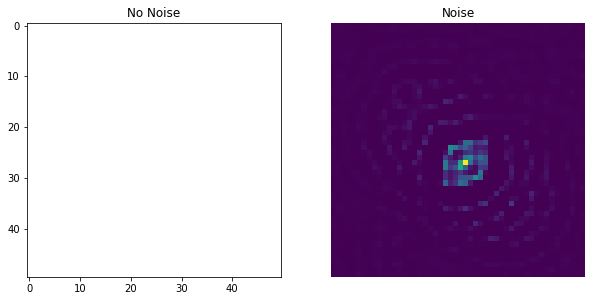

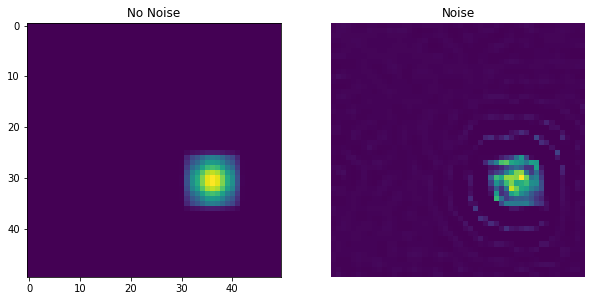

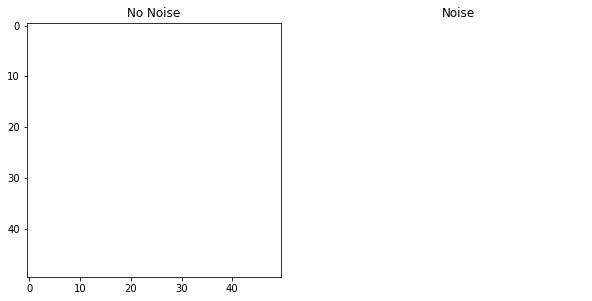

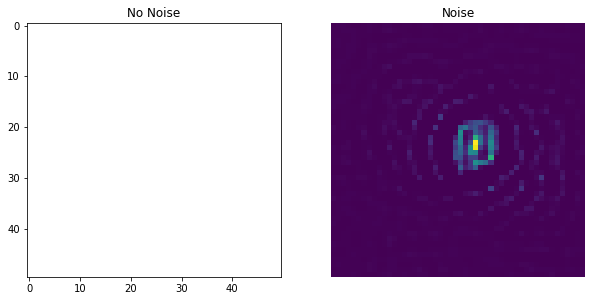

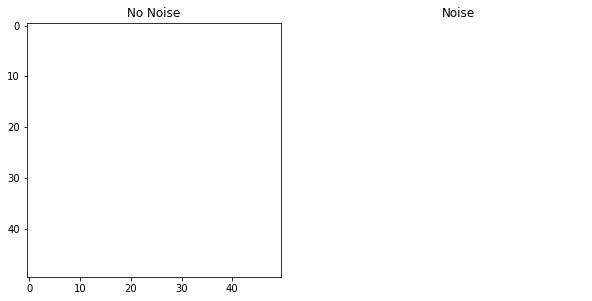

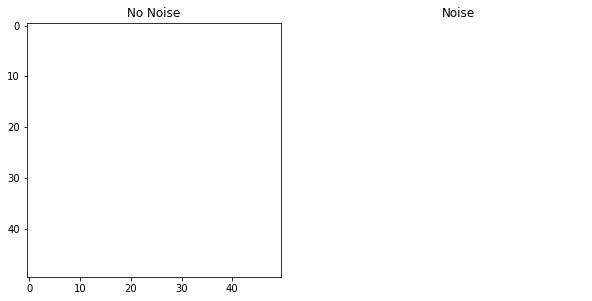

In [495]:
plot_compare(qyes[0], qno[0])  

0
1
2
3
4
5


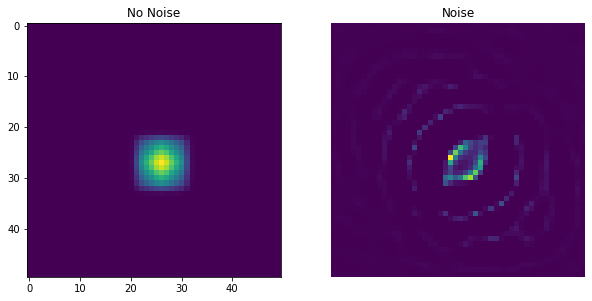

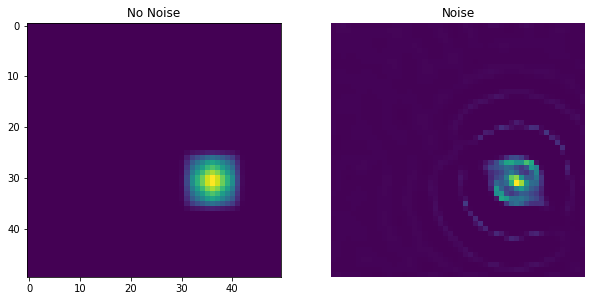

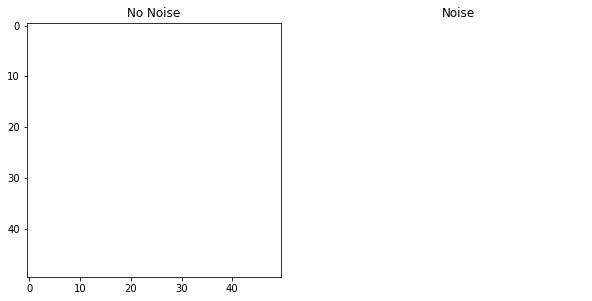

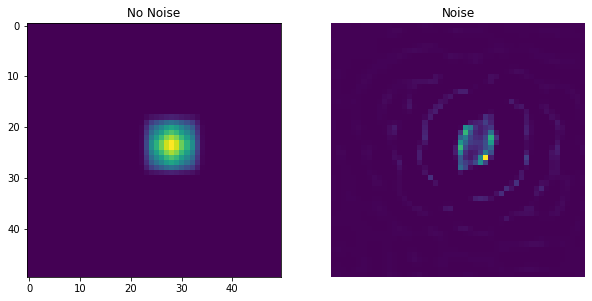

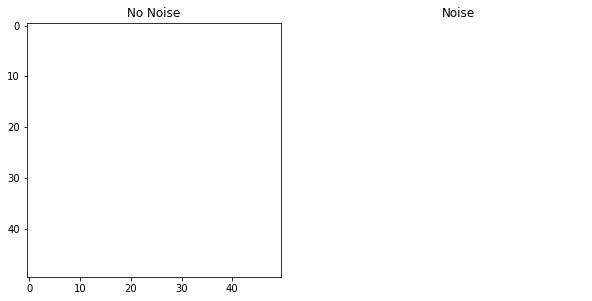

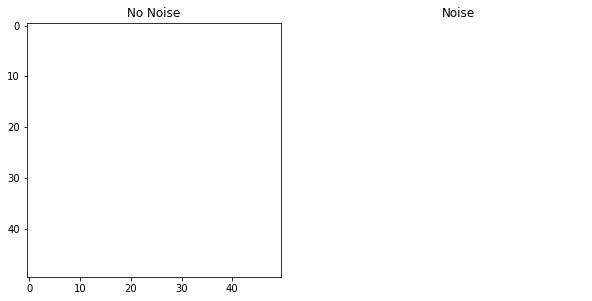

In [496]:
plot_compare(qyes[1], qno[1]) 

0
1
2
3
4
5


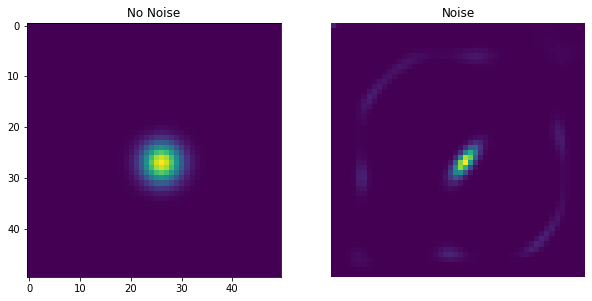

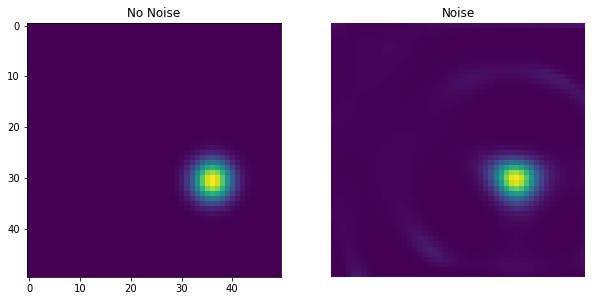

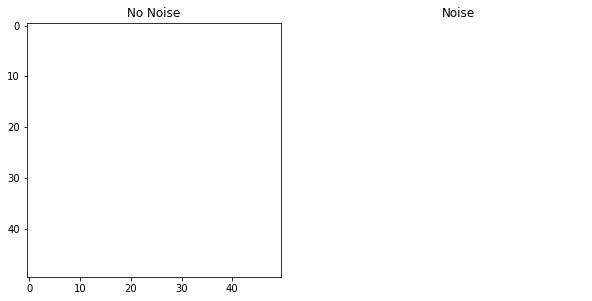

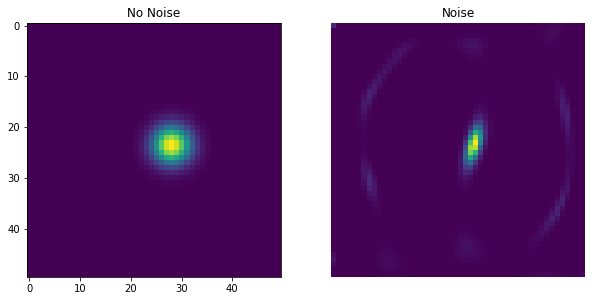

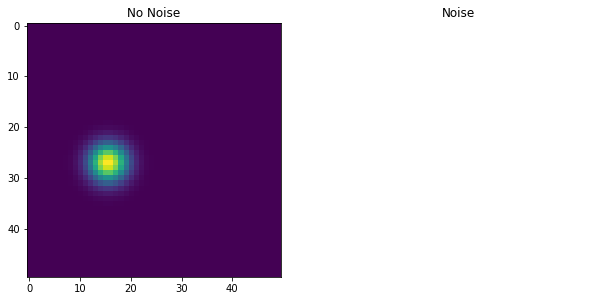

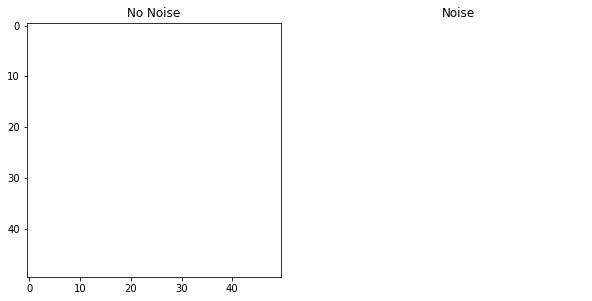

In [497]:
plot_compare(qyes[2], qno[2]) 

0
1
2
3
4
5


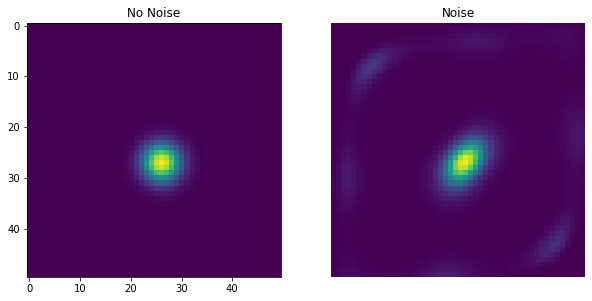

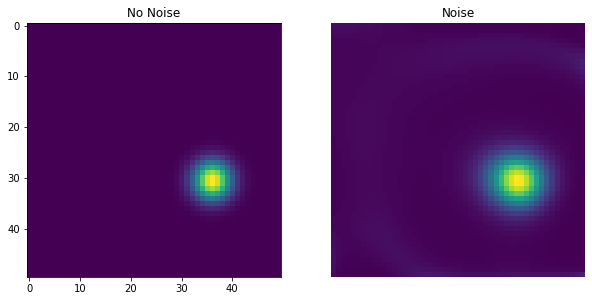

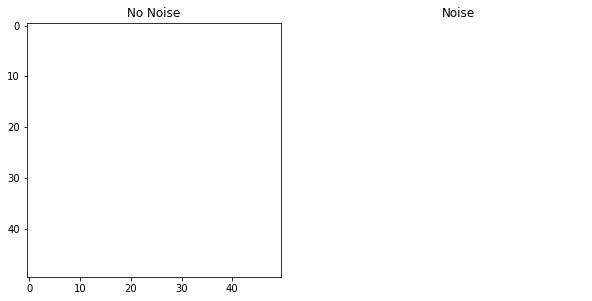

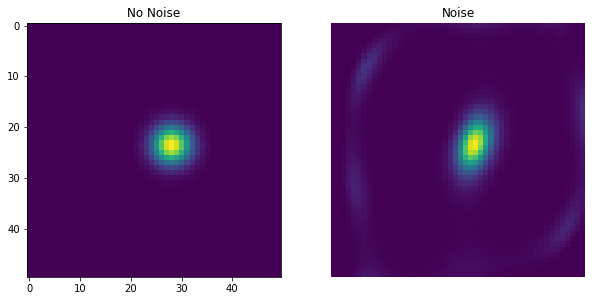

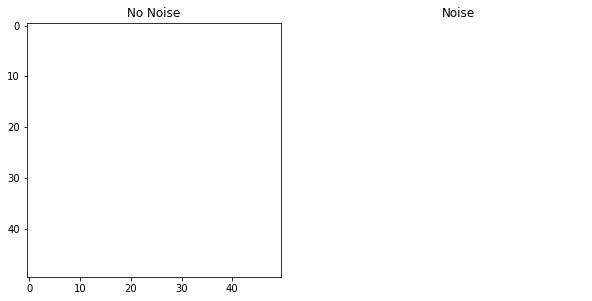

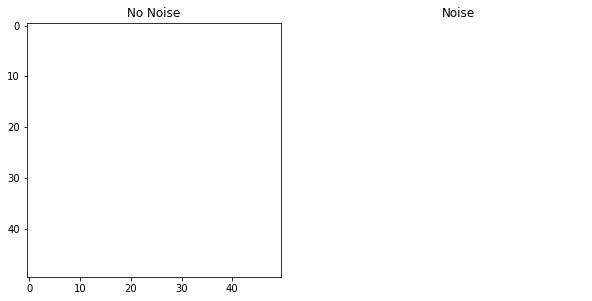

In [498]:
plot_compare(qyes[3], qno[3]) 

print(len(q_noise))

0
1
2
3
4
5


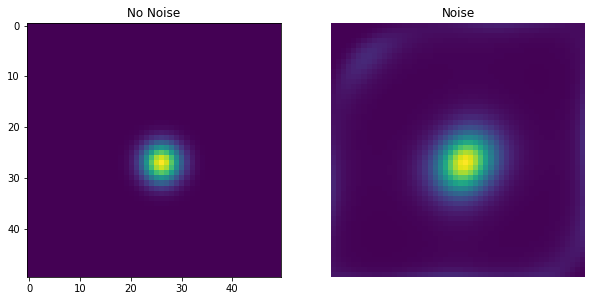

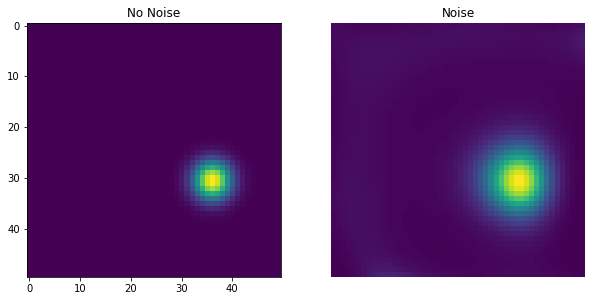

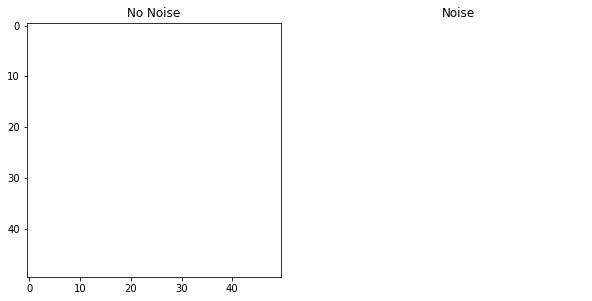

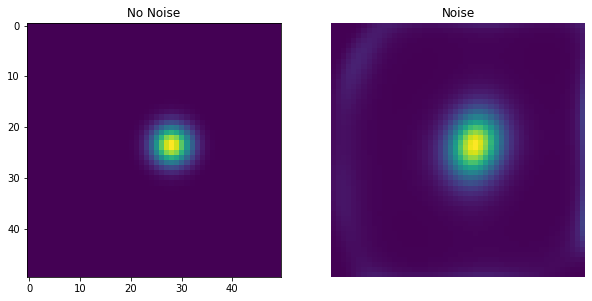

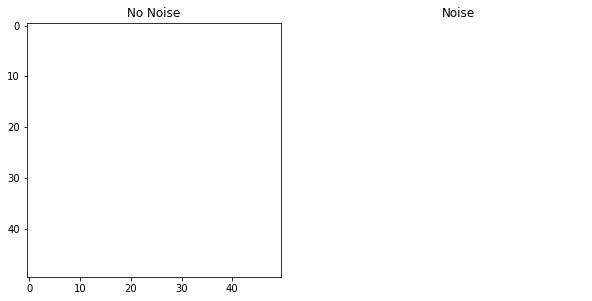

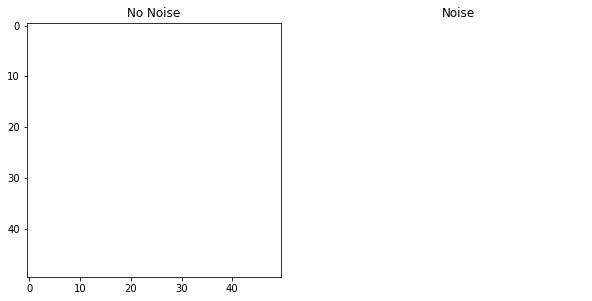

In [499]:
plot_compare(qyes[4], qno[4]) 

0
1
2
3
4
5


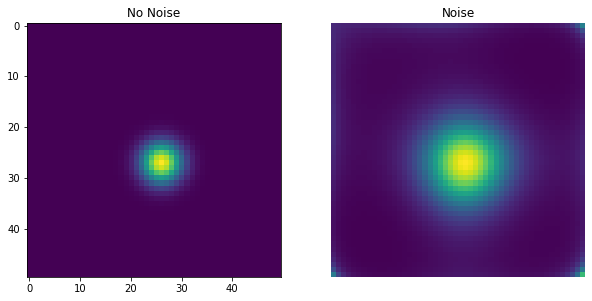

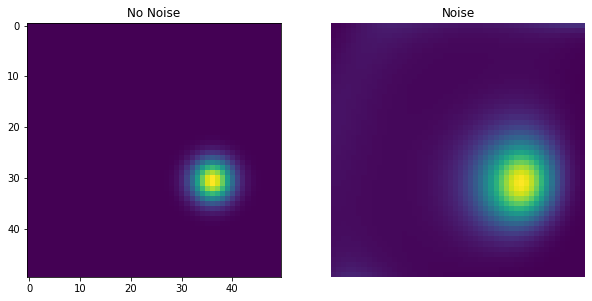

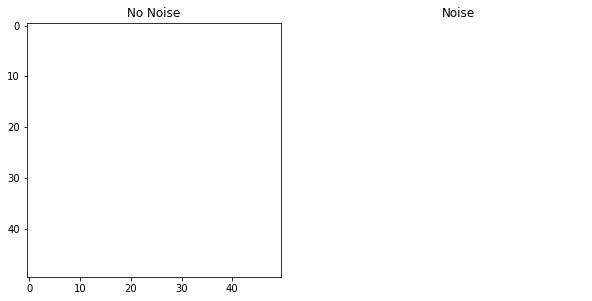

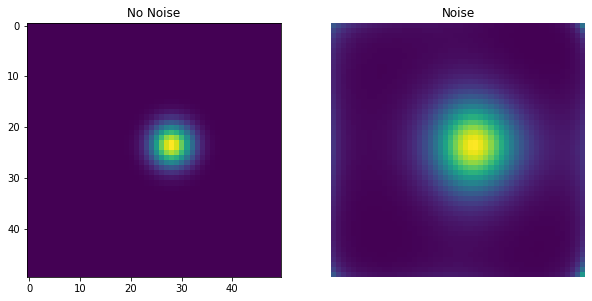

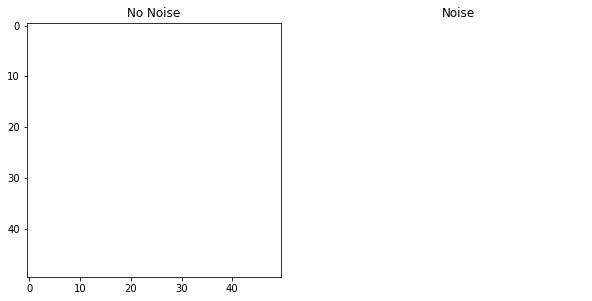

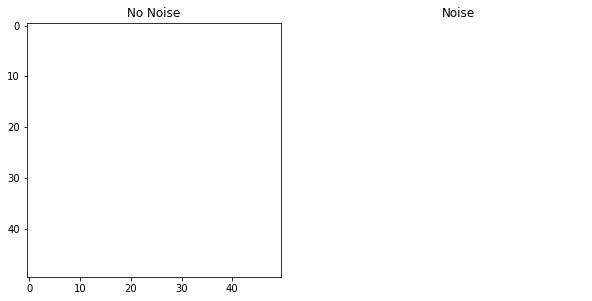

In [500]:
plot_compare(qyes[5], qno[5]) 

0
1
2
3
4
5


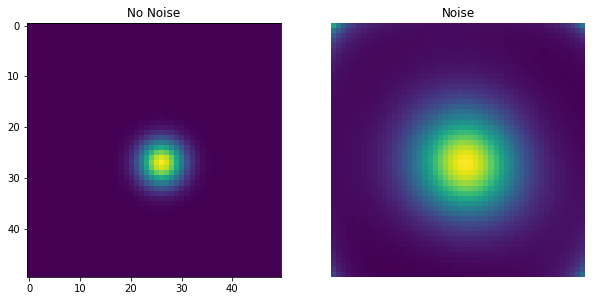

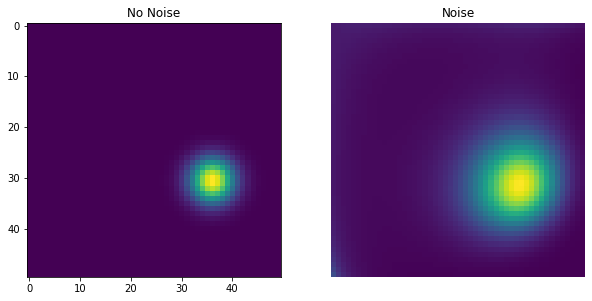

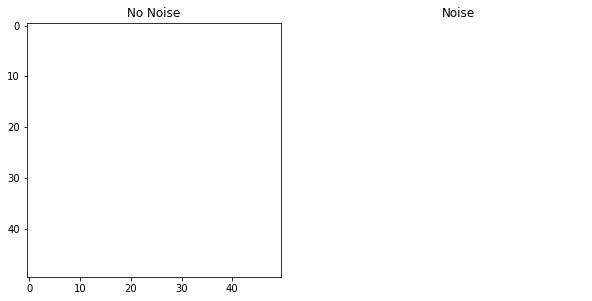

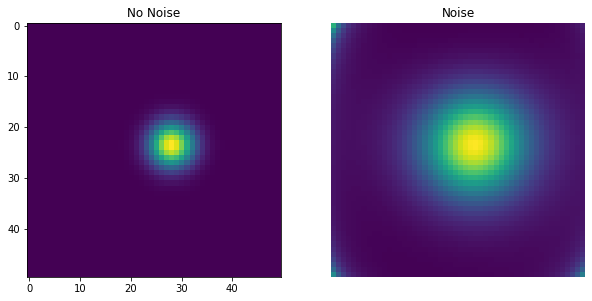

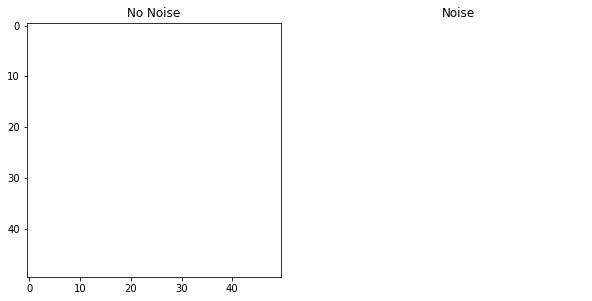

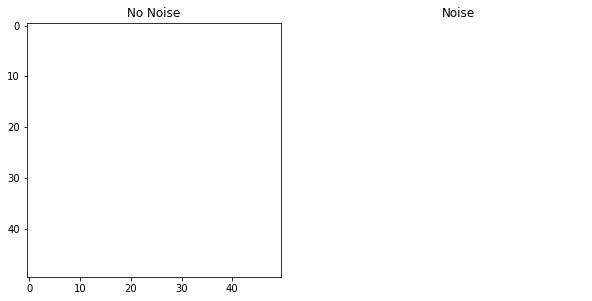

In [501]:
plot_compare(qyes[6], qno[6]) 

In [345]:
#plotting just the barycenters

def plot_compare(q_noise, q_nonoise):
    j = 0
    for i in range(0,len(q_noise)*2,2):
        print(i+1)
        plt.figure(1, figsize=(10,10))
        plt.subplot(3,2,i+1)
        plt.imshow(q_nonoise[j])
        plt.title("No Noise")
        print(i+2)
        plt.subplot(3,2,i+2)
        plt.imshow(q_noise[j])
        plt.title("Noise")
        plt.axis("off")
        
        j+=1

plot_compare(q_noise, q_nonoise) 

3


NameError: name 'noise15' is not defined

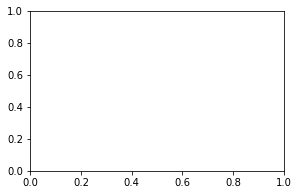

In [354]:

#plotting results
plt.figure(1, figsize=(10,10))
plt.subplot(3,2,1)
plt.imshow(noise15)
plt.title("Noisy Image 15")
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(no_noise15)
plt.title("Non-Noisy Image 15")
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(noise95)
plt.title("Noisy Image 95")
plt.axis("off")

plt.subplot(2,2,4)
plt.imshow(no_noise95)
plt.title("Non-Noisy Image 95")
plt.axis('off')



plt.figure(2, figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(q_noise)
plt.title("Debiased Barycenter with Noise")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(q_nonoise)
plt.title("Debiased Barycenter with No Noise")
plt.axis('off')


#print(P_noise[0][14])
#print(q_noise[0])
#print(q_nonoise[0])

(-0.5, 49.5, 49.5, -0.5)

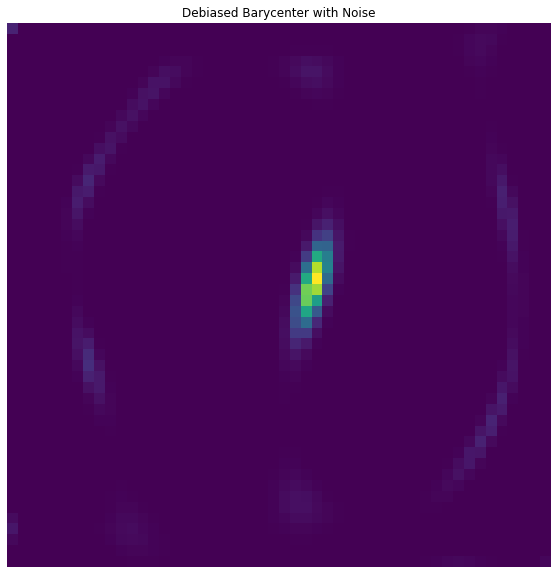

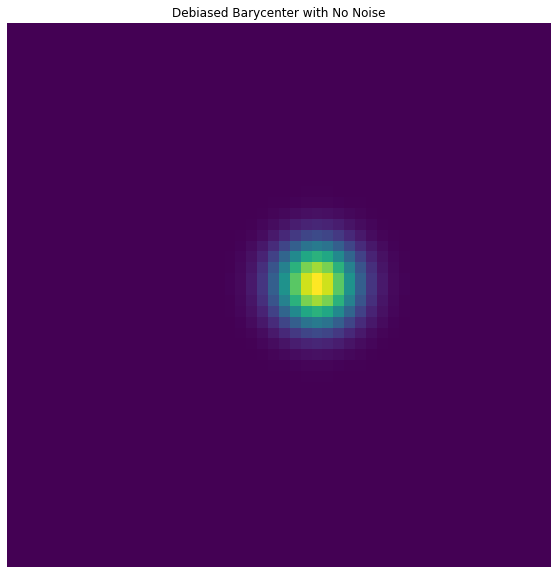

In [343]:
plt.figure(2, figsize=(10,10))
plt.imshow(q_noise[2])
plt.title("Debiased Barycenter with Noise")
plt.axis("off")

plt.figure(1, figsize=(10,10))
plt.imshow(q_nonoise[2])
plt.title("Debiased Barycenter with No Noise")
plt.axis('off')

In [ ]:


#rng = np.random.RandomState(42)
#n = 2
#index = rng.choice(np.arange(200), size=(n), replace=False)
#index.sort()
#print(index)


#can add index back here
noise15 = np.load("./artificial_data.npy")[15, :, :]
no_noise15 = np.load("./artificial_data_no_noise.npy")[15, :, :]
noise95 = np.load("./artificial_data.npy")[95, :, :]
no_noise95 = np.load("./artificial_data_no_noise.npy")[95, :, :]


P_noise = np.array([noise15,noise95])
P_nonoise = np.array([no_noise15, no_noise95])


C = ot.dist(noise15, noise95)
print(C)
#normalize
#C /= C.max()
expC = lambda i: math.exp(-i/epsilon)
expC = np.vectorize(expC)

K = expC(C)
print(K.shape)

#noiseP =  torch.Tensor(noise)
P =  torch.from_numpy(P_nonoise)
K = torch.from_numpy(K)